In [ ]:
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.layers import Input, Flatten, Embedding, multiply, Dropout
from keras.layers import Concatenate, GaussianNoise,Activation
from keras.optimizers import Adam
from keras.utils import np_utils, to_categorical
from keras import initializers
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


download cifar10 data

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


define name of classes

In [ ]:
num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']


plot some pictures

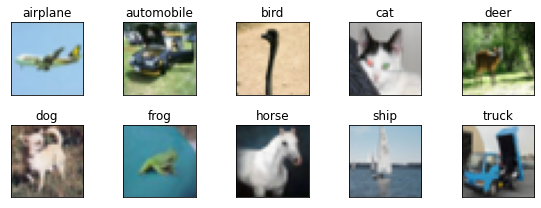

In [ ]:

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(img)
    
plt.tight_layout()

reshape data and convert labels into one-hot vector

In [ ]:

X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
input_shape = (32, 32, 3)
    

Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)


normalizing Data and change into range  -1 and 1

In [ ]:
X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

X_test = np.float32(X_test)
X_test = (X_test / 255 - 0.5) * 2
X_test = np.clip(X_test, -1, 1)

##create Generator
use transposed CNN (inverse)

latent space dimension = (100,)
 class size = (10,)

 (concate latent space and classes as input)

  parameters of each layers:
  - input = normal distribution z abd unknown character
  - activation function = Leaky RelU
  - batch Normalization 
  - stride = 2
  - last activation function = RelU


In [ ]:
z = Input(shape=(100,))
labels = Input(shape=(10,))
merged_layer = Concatenate()([z, labels])

generator = Dense(2*2*512, activation='relu')(merged_layer)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)
generator = Reshape((2, 2, 512))(generator)

generator = Conv2DTranspose(256, kernel_size=5, strides=2, padding='same')(generator)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)

generator = Conv2DTranspose(128, kernel_size=5, strides=2, padding='same')(generator)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)

generator = Conv2DTranspose(64, kernel_size=5, strides=2, padding='same')(generator)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)

generator = Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh')(generator)

generator = Model(inputs=[z, labels], outputs=generator)

## create Discriminator
use CNN
  and fully connected = flatten,dense1(512,relu),dense2(1,sigmoid)
  parameters of each layers:
  - activation function = LeakyRelU
  - batch Normalization 
  - stride = 2

compile' parameters:
 - optimazer = adam
 - learning rate = 0.0002
 - loss function = binary_crossentropy


In [ ]:
img_input = Input(shape=(X_train[0].shape))

discriminator = Conv2D(64, kernel_size=5, strides=2, padding='same')(img_input)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

discriminator = Conv2D(128, kernel_size=5, strides=2, padding='same')(discriminator)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

discriminator = Conv2D(256, kernel_size=5, strides=2, padding='same')(discriminator)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)
 
discriminator = Conv2D(512, kernel_size=5, strides=2, padding='same')(discriminator)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

discriminator = Flatten()(discriminator)

merged_layer = Concatenate()([discriminator, labels])
discriminator = Dense(512, activation='relu')(merged_layer)
discriminator = Dense(1, activation='sigmoid')(discriminator)

discriminator = Model(inputs=[img_input, labels], outputs=discriminator)

discriminator.compile(Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy',metrics=['binary_accuracy'])

#### CGAN
generator && discriminator

compile' parameter:
- optimizer = adam
- loss function = binary_accuracy
- learning rate = 0.0004
- epochs = 100
- batch size = 64

In [ ]:
label = Input(shape=(10,), name='label')
z = Input(shape=(100,), name='z')

discriminator.trainable = False
fake_img = generator([z, label])
validity = discriminator([fake_img, label])

d_g = Model([z, label], validity)

d_g.compile(Adam(lr=0.0004, beta_1=0.5), loss='binary_crossentropy',
            metrics=['binary_accuracy'])

In [ ]:
# prints a summary representation of your model
d_g.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z (InputLayer)                  (None, 100)          0                                            
__________________________________________________________________________________________________
label (InputLayer)              (None, 10)           0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 32, 32, 3)    4543363     z[0][0]                          
                                                                 label[0][0]                      
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            5365121     model_1[1][0]              

## Fit model
generate fake image by generator model
calculate loss by discriminating fake image and original train data

plot generated image per each 10 epochs

epoch = 1/100, d_loss=0.414, g_loss=4.084                                                                                                     


epoch = 2/100, d_loss=0.323, g_loss=2.731                                                                                                     
epoch = 3/100, d_loss=0.332, g_loss=2.864                                                                                                     
epoch = 4/100, d_loss=0.256, g_loss=3.988                                                                                                     
epoch = 5/100, d_loss=0.332, g_loss=3.415                                                                                                     
epoch = 6/100, d_loss=0.207, g_loss=2.095                                                                                                     
epoch = 7/100, d_loss=0.240, g_loss=2.892                                                                                                     
epoch = 8/100, d_loss=0.392, g_loss=3.265                                                                                                     

epoch = 12/100, d_loss=0.196, g_loss=4.866                                                                                                     
epoch = 13/100, d_loss=0.276, g_loss=2.159                                                                                                     
epoch = 14/100, d_loss=0.379, g_loss=4.003                                                                                                     
epoch = 15/100, d_loss=0.244, g_loss=8.218                                                                                                     
epoch = 16/100, d_loss=0.206, g_loss=5.633                                                                                                     
epoch = 17/100, d_loss=0.198, g_loss=4.579                                                                                                     
epoch = 18/100, d_loss=0.251, g_loss=4.576                                                                                              

epoch = 22/100, d_loss=0.172, g_loss=2.729                                                                                                     
epoch = 23/100, d_loss=0.199, g_loss=5.381                                                                                                     
epoch = 24/100, d_loss=0.173, g_loss=6.435                                                                                                     
epoch = 25/100, d_loss=0.188, g_loss=2.908                                                                                                     
epoch = 26/100, d_loss=0.639, g_loss=0.553                                                                                                     
epoch = 27/100, d_loss=0.184, g_loss=10.201                                                                                                     
epoch = 28/100, d_loss=0.166, g_loss=1.295                                                                                             

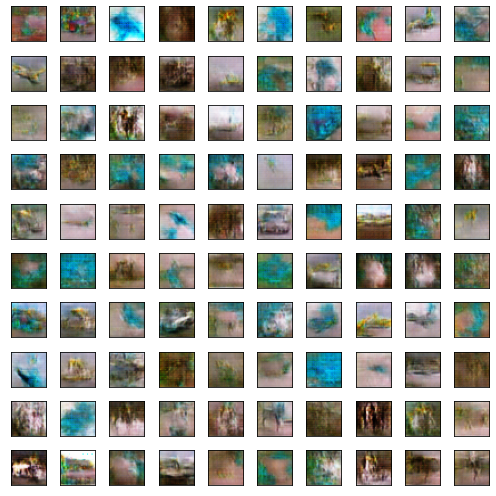

epoch = 32/100, d_loss=0.210, g_loss=5.564                                                                                                     
epoch = 33/100, d_loss=0.210, g_loss=1.423                                                                                                     
epoch = 34/100, d_loss=0.181, g_loss=0.588                                                                                                     
epoch = 35/100, d_loss=0.175, g_loss=1.780                                                                                                     
epoch = 36/100, d_loss=0.177, g_loss=1.162                                                                                                     
epoch = 37/100, d_loss=0.174, g_loss=1.501                                                                                                     
epoch = 38/100, d_loss=0.185, g_loss=18.695                                                                                             

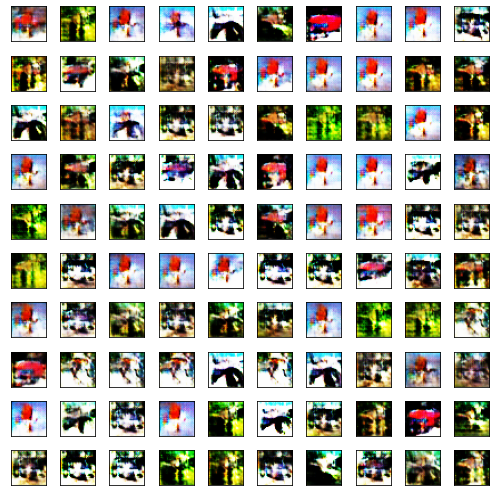

epoch = 42/100, d_loss=0.165, g_loss=1.555                                                                                                     
epoch = 43/100, d_loss=0.190, g_loss=0.636                                                                                                     
epoch = 44/100, d_loss=0.169, g_loss=23.402                                                                                                     
epoch = 45/100, d_loss=0.168, g_loss=9.969                                                                                                     
epoch = 46/100, d_loss=0.374, g_loss=19.116                                                                                                     
epoch = 47/100, d_loss=0.186, g_loss=4.735                                                                                                     
epoch = 48/100, d_loss=0.168, g_loss=7.703                                                                                            

epoch = 52/100, d_loss=0.188, g_loss=10.541                                                                                                     
epoch = 53/100, d_loss=0.257, g_loss=15.327                                                                                                     
epoch = 54/100, d_loss=0.174, g_loss=11.889                                                                                                     
epoch = 55/100, d_loss=0.181, g_loss=9.840                                                                                                     
epoch = 56/100, d_loss=0.186, g_loss=5.878                                                                                                     
epoch = 57/100, d_loss=0.181, g_loss=8.642                                                                                                     
epoch = 58/100, d_loss=0.172, g_loss=4.310                                                                                           

epoch = 62/100, d_loss=0.172, g_loss=5.682                                                                                                     
epoch = 63/100, d_loss=0.176, g_loss=9.348                                                                                                     
epoch = 64/100, d_loss=0.170, g_loss=7.432                                                                                                     
epoch = 65/100, d_loss=0.293, g_loss=12.283                                                                                                     
epoch = 66/100, d_loss=0.168, g_loss=5.804                                                                                                     
epoch = 67/100, d_loss=0.198, g_loss=10.205                                                                                                     
epoch = 68/100, d_loss=0.172, g_loss=9.622                                                                                            

epoch = 72/100, d_loss=0.176, g_loss=8.769                                                                                                     
epoch = 73/100, d_loss=0.174, g_loss=8.157                                                                                                     
epoch = 74/100, d_loss=0.177, g_loss=7.804                                                                                                     
epoch = 75/100, d_loss=0.167, g_loss=9.575                                                                                                     
epoch = 76/100, d_loss=0.171, g_loss=5.871                                                                                                     
epoch = 77/100, d_loss=0.171, g_loss=4.419                                                                                                     
epoch = 78/100, d_loss=0.183, g_loss=6.881                                                                                              

epoch = 82/100, d_loss=0.172, g_loss=8.862                                                                                                     
epoch = 83/100, d_loss=0.181, g_loss=6.205                                                                                                     
epoch = 84/100, d_loss=0.165, g_loss=8.420                                                                                                     
epoch = 85/100, d_loss=0.228, g_loss=10.225                                                                                                     
epoch = 86/100, d_loss=0.177, g_loss=9.926                                                                                                     
epoch = 87/100, d_loss=0.173, g_loss=7.086                                                                                                     
epoch = 88/100, d_loss=0.171, g_loss=6.782                                                                                             

epoch = 92/100, d_loss=0.171, g_loss=6.268                                                                                                     
epoch = 93/100, d_loss=0.168, g_loss=31.424                                                                                                     
epoch = 94/100, d_loss=0.178, g_loss=5.914                                                                                                     
epoch = 95/100, d_loss=0.169, g_loss=5.312                                                                                                     
epoch = 96/100, d_loss=0.171, g_loss=6.149                                                                                                     
epoch = 97/100, d_loss=0.192, g_loss=5.122                                                                                                     
epoch = 98/100, d_loss=0.171, g_loss=10.243                                                                                            

In [ ]:
epochs = 100
batch_size = 100
smooth = 0.1
latent_dim = 100

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []
num = len(X_train) // batch_size
for e in range(epochs + 1):
    for i in range(num):
        discriminator.trainable = True
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        real_labels = to_categorical(y_train[i*batch_size:(i+1)*batch_size].reshape(-1, 1), num_classes=10)
        d_loss_real = discriminator.train_on_batch(x=[X_batch, real_labels],y=real * (1 - smooth))
        
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = to_categorical(np.random.randint(0, 10, batch_size).reshape(-1, 1), num_classes=10)
        X_fake = generator.predict_on_batch([z, random_labels])
        
        d_loss_fake = discriminator.train_on_batch(x=[X_fake, random_labels], y=fake)
        #distriminator loss 
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        discriminator.trainable = False
        
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = to_categorical(np.random.randint(0, 10, batch_size).reshape(-1, 1), num_classes=10)
        d_g_loss_batch = d_g.train_on_batch(x=[z, random_labels], y=real)
        print('epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i,num, d_loss_batch, d_g_loss_batch[0]),100*' ',end='\r')
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')
    if e % 10 == 0:
        samples = 100
        z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
        labels = to_categorical(np.random.randint(0, 10, samples).reshape(-1, 1), num_classes=10)
        x_fake = generator.predict([z, labels])
        x_fake = np.clip(x_fake, -1, 1)

        plt.figure(figsize=(7,7))
        for k in range(samples):
            plt.subplot(10, 10, k + 1, xticks=[], yticks=[])
            plt.imshow(((X_fake[k] + 1)* 127).astype(np.uint8))

        plt.tight_layout()
        plt.show()

**plot loss per each epoch**

In [ ]:
X_fake.shape

In [ ]:
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()